<h1 align="center"> ECE4076/5176 - Week 12 </h1>
<h1 align="center"; style="color: purple;"> Fun with OpenAI- Contrastive Language-Image Pretraining (CLIP) </h1>


Throughout this unit, we have mostly only considered images as input, but what if we want to condition on other information. We've already had a taste of this when we built the conditional GAN, but we can apply this same strategy to any sort of data. Let's look at a cool approach that maps text and images together. CLIP learns to map text and images into representations that look similar, basically the model is trained to learn which text embeddings and images were paired together. The image below shows this objective, we will take a bunch of images, and train an image encoder to learn a representation of these. We will do the same with a text description. The loss we will use seeks to make some distance (eg. cosine) betweem these embeddings small for matching text and images, and large (contrastive) for unmatched pairs. Once we have this, we can do a lot of interesting things. 

![The clip model](https://images.openai.com/blob/fbc4f633-9ad4-4dc2-bd94-0b6f1feee22f/overview-a.svg)

Let's see how we can do *unsupervised* object recognition using a pre-trained clip model. You need to have the following packages to work with this notebook
- [pytorch](https://pytorch.org/)
- [OpenCV](https://pypi.org/project/opencv-python/)
- [numpy](https://anaconda.org/anaconda/numpy)
- [matplotlib](https://anaconda.org/conda-forge/matplotlib)
- [pillow](https://pillow.readthedocs.io/en/stable/)
- [CLIP](https://github.com/openai/CLIP.git)

To install CLIP, you need to run the following command
!pip install git+https://github.com/openai/CLIP.git


In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import time
from datetime import timedelta
import requests
import os

# import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline



In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


<div class="alert alert-block alert-info">
    
<h1> CLIP</h1> 
</div>

ClIP is a vision-language model. 
By matching text descriptions of images to their visual information, it learns associations between the language and vision.  Below, we check the vision models provided by OpenAI and opt for using a simple ResNet model (a CNN). CLIP comes with bigger and more powerful vision encoders such as Vision Transformer (ViT) (eg., ViT-B/32). Feel free to investigate those models as well.

In [4]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
model, preprocess = clip.load("RN50")
model.to(device).eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 244M/244M [01:47<00:00, 2.38MiB/s]


Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


<div class="alert alert-block alert-info">
    
## Language Tokenizer  

</div>

To employ the CLIP, we need to process language. CLIP comes with a language model (LM). The first step in processing text data is to convert a sentence into tokens. Check out the code below, do you see any patterns? 


In [6]:
token_clip = clip.tokenize("Hello").numpy()
print("Tokenizing the word \"Hello\":", token_clip[0,:4],"\n")
token_clip = clip.tokenize("Hello World").numpy()
print("Tokenizing the word \"Hello World\":", token_clip[0,:4],"\n")
token_clip = clip.tokenize("Hello World!").numpy()
print("Tokenizing the word \"Hello World!\":", token_clip[0,:4],"\n")

Tokenizing the word "Hello": [49406  3306 49407     0] 

Tokenizing the word "Hello World": [49406  3306  1002 49407] 

Tokenizing the word "Hello World!": [49406  3306  1002   256] 



As you might have guessed, the tokenizer uses some symbols to label words in a sequence. Every sequence starts with a Start-Of-Sequence (SoS) token and finishes with a End-of-Sequence (EoS) token. There is an Unknown token to describe every word that the CLIP language model does not understand. 

To have some fun, I am using the classes from the CIFAR100 to create a Zero-Shot Image Classifier. First, let's see what those classes are:

In [7]:
ZSL_classes = ["beaver", "dolphin", "otter", "seal", "whale",
               "aquarium fish", "flatfish", "ray", "shark",
               "trout", "orchids", "poppies", "roses", 
               "sunflowers", "tulips", "bottles", "bowls", "cans", 
               "cups", "plates", "apples", "mushrooms", "oranges", 
               "pears", "sweet peppers", "clock", 
               "computer keyboard", "lamp", "telephone", "television",
               "bed", "chair", "couch", "table", "wardrobe",
               "bee", "beetle", "butterfly", "caterpillar", 
               "bear", "leopard", "lion", "tiger", "wolf",
               "bridge", "castle", "house", "road", "skyscraper",
               "cloud", "forest", "mountain", "plain", "sea",
               "camel", "cattle", "chimpanzee", "elephant", "kangaroo",
               "fox", "porcupine", "possum", "raccoon", "skunk",
               "crab", "lobster", "snail", "spider", "worm",
               "baby", "boy", "girl", "man", "woman",
               "crocodile", "dinosaur", "lizard", "snake", "turtle",
               "hamster", "mouse", "rabbit", "shrew", "squirrel",
               "maple", "oak", "palm", "pine", "willow",
               "bicycle", "bus", "motorcycle", "pickup truck", "train",
               "lawn-mower", "rocket", "streetcar", "tank", "tractor"]





Next, for each class, we create a prompt in the form "This is a photo of [Class]". Using prompts is shown to improve the quality of our inference so instead of describing class of "cats" by feeding the word cat to the model, we describe it by the prompt "This is a photo of a cat". The code below does this for us. 

In [8]:
text_descriptions = [f"This is a photo of a {label}" for label in ZSL_classes]
text_tokens = clip.tokenize(text_descriptions).to(device)

with torch.no_grad():
    # Text features
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
text_features.shape

torch.Size([99, 1024])

<div class="alert alert-block alert-info">
    
## Zero-Shot Image Classification  

</div>

Each text feature above represent its corresponding class. With CLIP, now what we can do is to feed its vision model an image, and obtain the corresponding representation. Then, we need to compare the visual representation with our text representation to identify the predictions. Below, we start by reading an image.

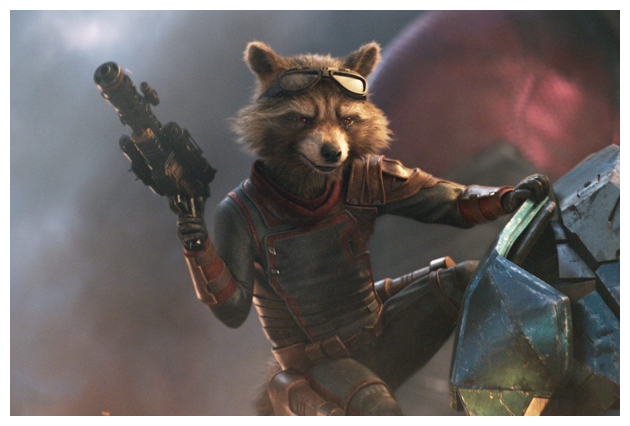

In [9]:
url = "https://images.immediate.co.uk/production/volatile/sites/3/2019/05/EBC1840_v228.1047-eb60675.jpg"

pil_img = Image.open(requests.get(url, stream=True).raw).convert("RGB")
plt.imshow(pil_img)
plt.axis('off')
plt.tight_layout()
plt.show()

Now, we feed the image to the CLIP model.

In [10]:
image_clip = preprocess(pil_img).unsqueeze(dim=0).to(device)

with torch.no_grad():
    # Image Features
    image_features = model.encode_image(image_clip).float()



Below, we compare the image features with text features. This can be done by computing the cosine similarity between the vectors. Note that above, we normalize the text features. Since norm of the image features is not going to change our preditions (it simply scales the similarities), we do not bother with normalizing the image features. Code below, first computes the (scaled) cosine similarity using the inner product and turn the resulting prediction into a probability vector using a softmax function. We plot the top 5 predictions as well.  

In [11]:
def zsl_clip(image_features):
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)
    top_probs = top_probs.detach().numpy().ravel()
    top_labels = top_labels.detach().numpy().ravel()
    return top_probs, top_labels

def plot_clip_output(pil_img, top_probs,top_labels):
    plt.subplot(1, 2,1)
    plt.imshow(pil_img)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs)
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [ZSL_classes[index] for index in top_labels])
    plt.xlabel("probability")

    plt.subplots_adjust(wspace=0.5)
    plt.show()




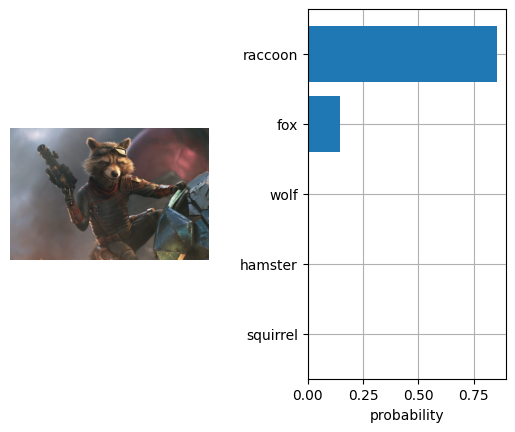

In [12]:
top_probs, top_labels = zsl_clip(image_features)
plot_clip_output(pil_img, top_probs,top_labels)

Maybe trying more?

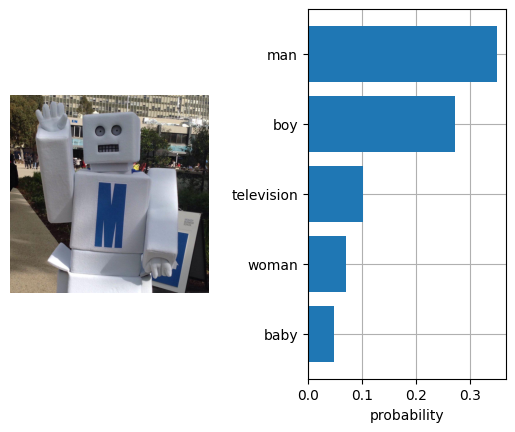

In [14]:
url = "https://styles.redditmedia.com/t5_2spbx/styles/communityIcon_gvfpgvaa4eo61.jpeg"

pil_img = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image_clip = preprocess(pil_img).unsqueeze(dim=0).to(device)

with torch.no_grad():
    # Image Features
    image_features = model.encode_image(image_clip).float()
top_probs, top_labels = zsl_clip(image_features)
plot_clip_output(pil_img, top_probs,top_labels)

Nice, we just got an object recognition model with no training data! Although, technically we did have a lot of training data, because we relied on openai to collect a number of images and text correspondences, and then just repurposed their model for our application. Some people refer to this as a foundation model. Note that their is no model training in this paradigm - you just need to collect appropriate labels for your use case. But you are dependent on a third party company/ supplier to provide the model, and your system will only ever be as good as their training data and model. This may be problematic depending on your application.